In [1]:
import glob
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import torch

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import CacheDataset, DataLoader, Dataset
from monai.inferers import sliding_window_inference
from monai.losses import DiceLoss, GeneralizedDiceLoss
from monai.metrics import compute_meandice
from monai.networks.layers import Norm
from monai.networks.nets import UNet
from monai.transforms import (
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadNiftid,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    ToTensord,
)
from monai.utils import first, set_determinism

print_config()

MONAI version: 0.3.0
Python version: 3.7.9 (default, Aug 31 2020, 07:22:35)  [Clang 10.0.0 ]
OS version: Darwin (19.6.0)
Numpy version: 1.19.1
Pytorch version: 1.6.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.1.1
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 8.0.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: 3.12.2
TorchVision version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.50.2

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [2]:
data_dir = "CLINIC_DATA"
print(data_dir)

CLINIC_DATA


In [3]:
train_images = sorted(glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
train_files, val_files = data_dicts[:-2], data_dicts[-2:]

In [4]:
set_determinism(seed=0)

In [5]:
train_transforms = Compose(
    [
        LoadNiftid(keys=["image", "label"],overwriting=True),
        AddChanneld(keys=["image", "label"]),
        #Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        #Orientationd(keys=["image", "label"], axcodes="RAS"),
        #ScaleIntensityRanged(
        #    keys=["image"], a_min=-57, a_max=164, b_min=0.0, b_max=1.0, clip=True,
        #),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(32, 32, 32),
            pos=1,
            neg=1,
            num_samples=1,
            image_key="image",
            image_threshold=0,
        ),
        # user can also add other random transforms
        # RandAffined(keys=['image', 'label'], mode=('bilinear', 'nearest'), prob=1.0, spatial_size=(96, 96, 96),
        #             rotate_range=(0, 0, np.pi/15), scale_range=(0.1, 0.1, 0.1)),
        ToTensord(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadNiftid(keys=["image", "label"],overwriting=True),
        AddChanneld(keys=["image", "label"]),
        #Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        #Orientationd(keys=["image", "label"], axcodes="RAS"),
        #ScaleIntensityRanged(
        #    keys=["image"], a_min=-57, a_max=164, b_min=0.0, b_max=1.0, clip=True,
        #),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        ToTensord(keys=["image", "label"]),
    ]
)

In [6]:
check_ds = Dataset(data=train_files, transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)


image shape: torch.Size([32, 32, 32]), label shape: torch.Size([32, 32, 32])


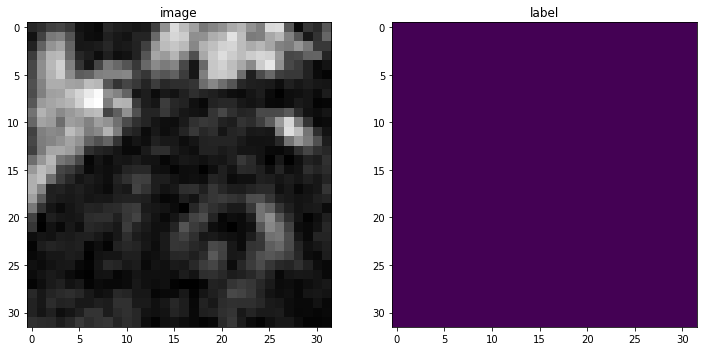

In [7]:
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 20], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 20])
plt.show()

image shape: torch.Size([32, 32, 32]), label shape: torch.Size([32, 32, 32])


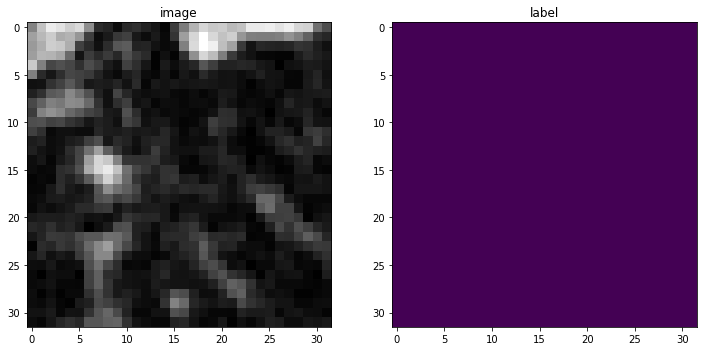

In [8]:
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 30], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 30])
plt.show()

In [11]:
#train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=4)
train_ds = Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)

#val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

In [12]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device('cpu')
model = UNet(
    dimensions=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
loss_function = GeneralizedDiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)

In [38]:
epoch_num = 900
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
metric_values = list()

for epoch in range(epoch_num):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{epoch_num}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            metric_sum = 0.0
            metric_count = 0
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                value = compute_meandice(
                    y_pred=val_outputs,
                    y=val_labels,
                    include_background=False,
                    to_onehot_y=True,
                    mutually_exclusive=True,
                )
                metric_count += len(value)
                metric_sum += value.sum().item()
            metric = metric_sum / metric_count
            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} at epoch: {best_metric_epoch}"
            )


epoch 708 average loss: 0.1669
----------
epoch 709/900
1/2, train_loss: 0.5555
2/2, train_loss: 0.5414
epoch 709 average loss: 0.5485
----------
epoch 710/900
1/2, train_loss: 0.1193
2/2, train_loss: 0.3191
epoch 710 average loss: 0.2192
----------
epoch 711/900
1/2, train_loss: 0.3061
2/2, train_loss: 0.3172
epoch 711 average loss: 0.3116
----------
epoch 712/900
1/2, train_loss: 0.3380
2/2, train_loss: 0.1236
epoch 712 average loss: 0.2308
----------
epoch 713/900
1/2, train_loss: 0.5549
2/2, train_loss: 0.3271
epoch 713 average loss: 0.4410
----------
epoch 714/900
1/2, train_loss: 0.5545
2/2, train_loss: 0.1437
epoch 714 average loss: 0.3491
----------
epoch 715/900
1/2, train_loss: 0.3059
2/2, train_loss: 0.3070
epoch 715 average loss: 0.3065
----------
epoch 716/900
1/2, train_loss: 0.1165
2/2, train_loss: 0.2954
epoch 716 average loss: 0.2059
----------
epoch 717/900
1/2, train_loss: 0.1034
2/2, train_loss: 0.5433
epoch 717 average loss: 0.3234
----------
epoch 718/900
1/2, tr

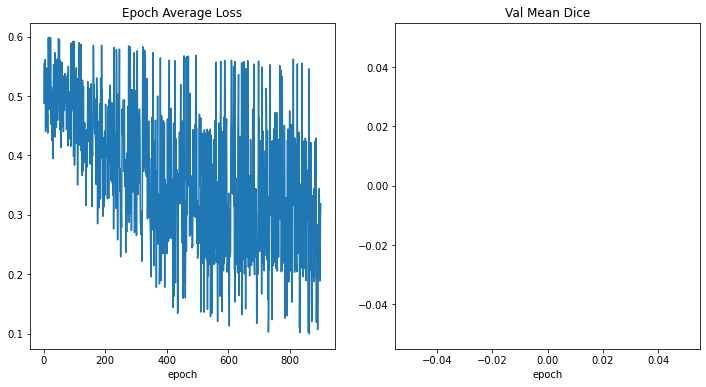

In [39]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

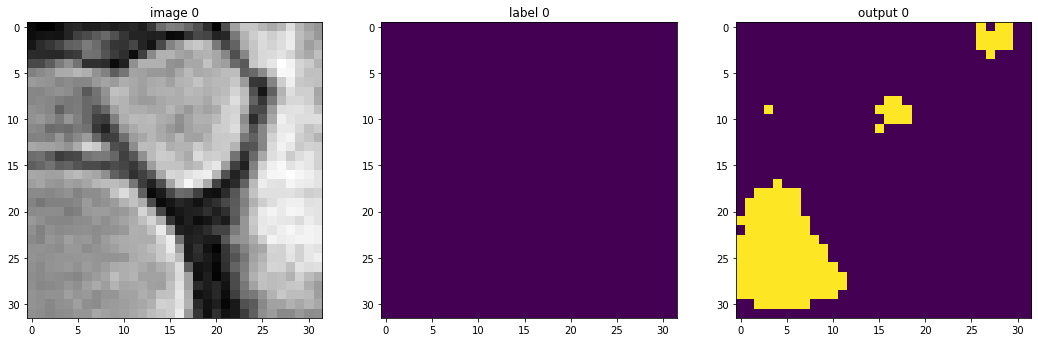

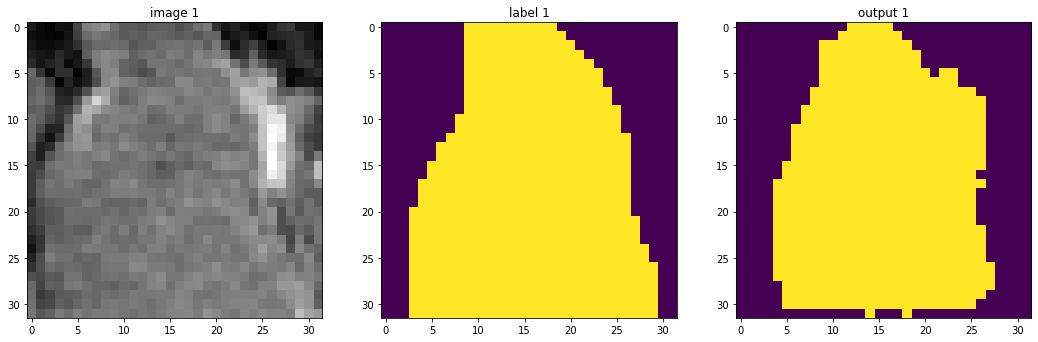

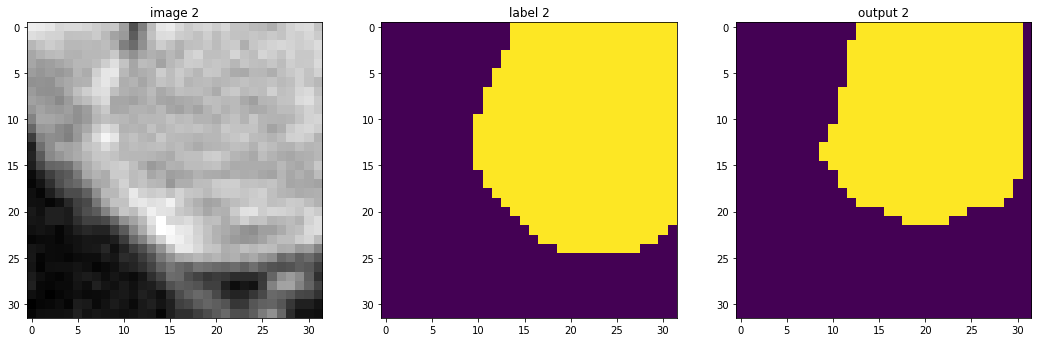

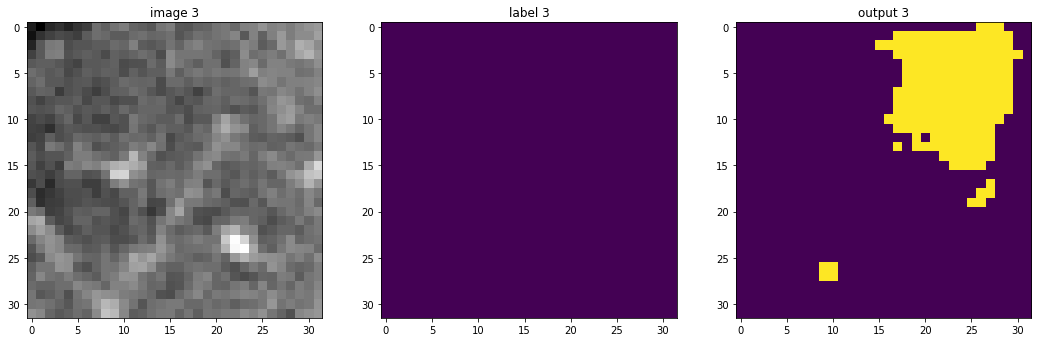

In [66]:
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=4)
model.eval()
with torch.no_grad():
    for i, train_data in enumerate(train_loader):
        roi_size = (64, 64, 32)
        sw_batch_size = 1
        val_outputs = sliding_window_inference(
            train_data["image"].to(device), roi_size, sw_batch_size, model
        )
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(train_data["image"][0, 0, :, :, 15], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(train_data["label"][0, 0, :, :, 15])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, 15])
        plt.show()


In [68]:
print(model)

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (norm): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act): PReLU(num_parameters=1)
        )
        (unit1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (norm): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act): PReLU(num_parameters=1)
        )
      )
      (residual): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(
            (unit0): Convolution(
              (conv): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
              (norm): BatchNo